In [28]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

import os
import tensorflow as tf
import time

from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

import pickle

import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

from numpy import array
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import seaborn as sns

In [2]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03', '04']
print(type(subjectList[1]))
#List of subjects

<class 'str'>


# AROUSAL

In [34]:
batch_size = 256
num_classes = 10
epochs = 200
input_shape=(70, 1)

In [35]:
def trainfold(foldnum):
    ### Preprocessing    
    with open('data_preprocessed_python\\fold_' + str(foldnum) + '_data_train_again3.npy', 'rb') as fileTrain:
        X  = np.load(fileTrain)
    
    with open('data_preprocessed_python\\fold_' + str(foldnum) + '_label_train_again3.npy', 'rb') as fileTrainL:
        Y  = np.load(fileTrainL)
    
    X = normalize(X)

    Arousal_Train = np.ravel(Y[:, [0]])
    Valence_Train = np.ravel(Y[:, [1]])
    Domain_Train = np.ravel(Y[:, [2]])
    Like_Train = np.ravel(Y[:, [3]])
    
    #######################################################################################
    Z = Arousal_Train
    #######################################################################################

    y_train = to_categorical(Z)
    print(y_train)

    x_train = np.array(X[:])
    
    with open('data_preprocessed_python\\fold_' + str(foldnum) + '_data_test_again3.npy', 'rb') as fileTrain:
        M  = np.load(fileTrain)
    
    with open('data_preprocessed_python\\fold_' + str(foldnum) + '_label_test_again3.npy', 'rb') as fileTrainL:
        N  = np.load(fileTrainL)
    M = normalize(M)

    Arousal_Test = np.ravel(N[:, [0]])
    Valence_Test = np.ravel(N[:, [1]])
    Domain_Test = np.ravel(N[:, [2]])
    Like_Test = np.ravel(N[:, [3]])
    
    #######################################################################################
    L = Arousal_Test
    #######################################################################################

    x_test = np.array(M[:])

    y_test = to_categorical(L)
    print(y_test)

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

    print(x_train.shape)
    
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint('fold_' + str(foldnum) + '_model_finalvalence.hdf5', monitor='accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)

    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint])
    
    print('Training Finished for fold' , foldnum)
    
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    print("score for fold", foldnum, "is", score)
    
    y_pred=model.predict(x_test)

    y_test1=np.argmax(y_test, axis=1)
    y_pred=np.argmax(y_pred,axis=1)

    cmatrix=confusion_matrix(y_test1, y_pred)

    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return history

In [36]:
# Fold 1

model = Sequential()
input_shape=(70, 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 70, 128)           512       
_________________________________________________________________
batch_normalization_8 (Batch (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 35, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_9 (Batch (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 17, 128)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2176)             

In [21]:
history1 = trainfold(1)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(62464, 70, 1)
Epoch 1/200
244/244 [==============================] - ETA: 0s - loss: 1.9203 - accuracy: 0.2601
Epoch 00001: accuracy improved from -inf to 0.26015, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 69s 282ms/step - loss: 1.9203 - accuracy: 0.2601 - val_loss: 1.8458 - val_accuracy: 0.2733
Epoch 2/200
244/244 [==============================] - ETA: 0s - loss: 1.8233 - accuracy: 0.2974
Epoch 00002: accuracy improved from 0.26015 to 0.29740, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 67s 273ms/step - loss: 1.8233 - accuracy: 0.2974 - val_loss: 1.6989 - val_accuracy: 0.3574
Epoch 3/

244/244 [==============================] - ETA: 0s - loss: 1.2024 - accuracy: 0.5599
Epoch 00024: accuracy improved from 0.55525 to 0.55986, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 59s 243ms/step - loss: 1.2024 - accuracy: 0.5599 - val_loss: 1.0770 - val_accuracy: 0.5974
Epoch 25/200
244/244 [==============================] - ETA: 0s - loss: 1.1846 - accuracy: 0.5673
Epoch 00025: accuracy improved from 0.55986 to 0.56729, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 60s 244ms/step - loss: 1.1846 - accuracy: 0.5673 - val_loss: 1.0894 - val_accuracy: 0.5868
Epoch 26/200
244/244 [==============================] - ETA: 0s - loss: 1.1766 - accuracy: 0.5701
Epoch 00026: accuracy improved from 0.56729 to 0.57012, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 60s 246ms/step - loss: 1.1766 - accuracy: 0.5701 - val_loss: 1.0668 - val_accuracy: 0.5977
Epoch 27

Epoch 68/200
128/244 [==============>...............] - ETA: 27s - loss: 0.8976 - accuracy: 0.6766
Epoch 00076: accuracy improved from 0.68297 to 0.68414, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 64s 261ms/step - loss: 0.8756 - accuracy: 0.6841 - val_loss: 0.8358 - val_accuracy: 0.6993
Epoch 77/200
244/244 [==============================] - ETA: 0s - loss: 0.8721 - accuracy: 0.6851
Epoch 00077: accuracy improved from 0.68414 to 0.68510, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 64s 263ms/step - loss: 0.8721 - accuracy: 0.6851 - val_loss: 0.8042 - val_accuracy: 0.7059
Epoch 78/200
244/244 [==============================] - ETA: 0s - loss: 0.8686 - accuracy: 0.6856
Epoch 00078: accuracy improved from 0.68510 to 0.68558, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 66s 270ms/step - loss: 0.8686 - accuracy: 0.6856 - val_loss: 0.8080 - val_accuracy: 0

Epoch 110/200
244/244 [==============================] - ETA: 0s - loss: 0.7739 - accuracy: 0.7269
Epoch 00110: accuracy improved from 0.72027 to 0.72685, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 61s 249ms/step - loss: 0.7739 - accuracy: 0.7269 - val_loss: 0.7564 - val_accuracy: 0.7345
Epoch 111/200
244/244 [==============================] - ETA: 0s - loss: 0.7739 - accuracy: 0.7268
Epoch 00112: accuracy did not improve from 0.72685
244/244 [==============================] - 60s 247ms/step - loss: 0.7739 - accuracy: 0.7268 - val_loss: 0.7383 - val_accuracy: 0.7427
Epoch 113/200
244/244 [==============================] - ETA: 0s - loss: 0.7704 - accuracy: 0.7256
Epoch 00113: accuracy did not improve from 0.72685
244/244 [==============================] - 60s 244ms/step - loss: 0.7704 - accuracy: 0.7256 - val_loss: 0.7460 - val_accuracy: 0.7371
Epoch 114/200
244/244 [==============================] - ETA: 0s - loss: 0.7601 - accuracy: 0.73

244/244 [==============================] - ETA: 0s - loss: 0.7044 - accuracy: 0.7530
Epoch 00142: accuracy improved from 0.75223 to 0.75304, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 34s 141ms/step - loss: 0.7044 - accuracy: 0.7530 - val_loss: 0.7113 - val_accuracy: 0.7599
Epoch 143/200
244/244 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.7533
Epoch 00143: accuracy improved from 0.75304 to 0.75328, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 33s 136ms/step - loss: 0.7062 - accuracy: 0.7533 - val_loss: 0.6972 - val_accuracy: 0.7640
Epoch 144/200
244/244 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.7562
Epoch 00144: accuracy improved from 0.75328 to 0.75623, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 33s 135ms/step - loss: 0.6991 - accuracy: 0.7562 - val_loss: 0.7036 - val_accuracy: 0.7595
Epoch 

244/244 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.7692
Epoch 00168: accuracy did not improve from 0.77387
244/244 [==============================] - 32s 132ms/step - loss: 0.6659 - accuracy: 0.7692 - val_loss: 0.6718 - val_accuracy: 0.7753
Epoch 169/200
244/244 [==============================] - ETA: 0s - loss: 0.6609 - accuracy: 0.7709
Epoch 00169: accuracy did not improve from 0.77387
244/244 [==============================] - 33s 134ms/step - loss: 0.6609 - accuracy: 0.7709 - val_loss: 0.6626 - val_accuracy: 0.7777
Epoch 170/200
244/244 [==============================] - ETA: 0s - loss: 0.6548 - accuracy: 0.7730
Epoch 00170: accuracy did not improve from 0.77387
244/244 [==============================] - 32s 133ms/step - loss: 0.6548 - accuracy: 0.7730 - val_loss: 0.6648 - val_accuracy: 0.7767
Epoch 171/200
244/244 [==============================] - ETA: 0s - loss: 0.6509 - accuracy: 0.7740
Epoch 00171: accuracy improved from 0.77387 to 0.77403, saving 

Epoch 195/200
244/244 [==============================] - ETA: 0s - loss: 0.6125 - accuracy: 0.7907
Epoch 00195: accuracy improved from 0.78839 to 0.79074, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 32s 133ms/step - loss: 0.6125 - accuracy: 0.7907 - val_loss: 0.6648 - val_accuracy: 0.7866
Epoch 196/200
244/244 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.7916
Epoch 00196: accuracy improved from 0.79074 to 0.79164, saving model to fold_1_model_finalvalence.hdf5
244/244 [==============================] - 32s 133ms/step - loss: 0.6118 - accuracy: 0.7916 - val_loss: 0.6535 - val_accuracy: 0.7861
Epoch 197/200
244/244 [==============================] - ETA: 0s - loss: 0.6175 - accuracy: 0.7884
Epoch 00197: accuracy did not improve from 0.79164
244/244 [==============================] - 32s 132ms/step - loss: 0.6175 - accuracy: 0.7884 - val_loss: 0.6593 - val_accuracy: 0.7892
Epoch 198/200
244/244 [=====================

In [39]:
def plot_graphs(foldnum, history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('fold' + str(foldnum) + 'model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('fold' + str(foldnum) + 'model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    #trying to combine both
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('fold' + str(foldnum) + 'model accuracy and loss: 200 epochs')
    plt.ylabel('accuracy/loss')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc','train_loss','val_loss'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


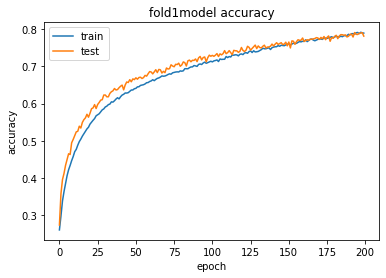

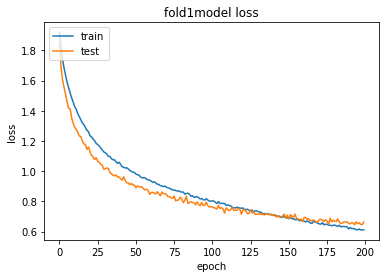

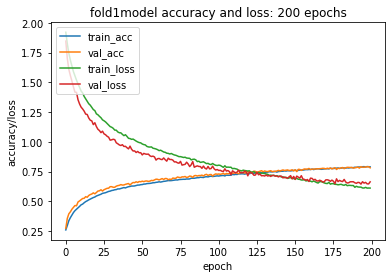

NameError: name 'x_test' is not defined

In [23]:
plot_graphs(1, history1)

In [41]:
# Fold 2

model = Sequential()
input_shape=(70, 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 70, 128)           512       
_________________________________________________________________
batch_normalization_12 (Batc (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 35, 128)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_13 (Batc (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 17, 128)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2176)             

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


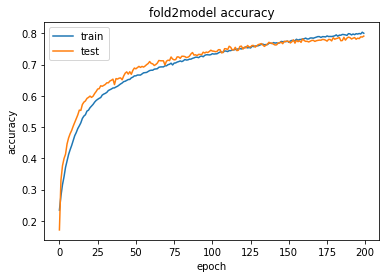

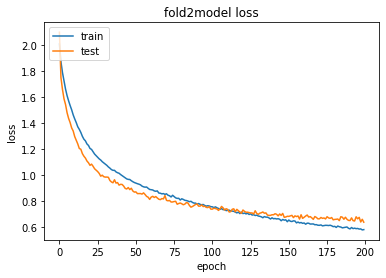

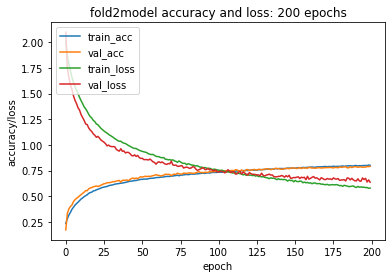

In [43]:
plot_graphs(2, history2)

In [44]:
# Fold 3

model = Sequential()
input_shape=(70, 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 70, 128)           512       
_________________________________________________________________
batch_normalization_14 (Batc (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 35, 128)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_15 (Batc (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 17, 128)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2176)            

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(62464, 70, 1)
Epoch 1/200
244/244 [==============================] - ETA: 0s - loss: 2.0377 - accuracy: 0.2344
Epoch 00001: accuracy improved from -inf to 0.23438, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 34s 141ms/step - loss: 2.0377 - accuracy: 0.2344 - val_loss: 2.4611 - val_accuracy: 0.1392
Epoch 2/200
244/244 [==============================] - ETA: 0s - loss: 1.8667 - accuracy: 0.2909
Epoch 00002: accuracy improved from 0.23438 to 0.29092, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 35s 143ms/step - loss: 1.8667 - accuracy: 0.2909 - val_loss: 1.7612 - val_accuracy: 0.3277
Epoch 3/

Epoch 24/200
244/244 [==============================] - ETA: 0s - loss: 1.1933 - accuracy: 0.5613
Epoch 00024: accuracy improved from 0.55637 to 0.56130, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 43s 178ms/step - loss: 1.1933 - accuracy: 0.5613 - val_loss: 1.0908 - val_accuracy: 0.5973
Epoch 25/200
244/244 [==============================] - ETA: 0s - loss: 1.1749 - accuracy: 0.5667
Epoch 00025: accuracy improved from 0.56130 to 0.56668, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 36s 147ms/step - loss: 1.1749 - accuracy: 0.5667 - val_loss: 1.0487 - val_accuracy: 0.6150
Epoch 26/200
244/244 [==============================] - ETA: 0s - loss: 1.1582 - accuracy: 0.5750
Epoch 00026: accuracy improved from 0.56668 to 0.57497, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 35s 144ms/step - loss: 1.1582 - accuracy: 0.5750 - val_loss: 1.0397 - val_accuracy: 0.

Epoch 49/200
244/244 [==============================] - ETA: 0s - loss: 0.9552 - accuracy: 0.6516
Epoch 00049: accuracy improved from 0.64940 to 0.65158, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 35s 144ms/step - loss: 0.9552 - accuracy: 0.6516 - val_loss: 0.8726 - val_accuracy: 0.6816
Epoch 50/200
244/244 [==============================] - ETA: 0s - loss: 0.9471 - accuracy: 0.6568
Epoch 00050: accuracy improved from 0.65158 to 0.65679, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 34s 140ms/step - loss: 0.9471 - accuracy: 0.6568 - val_loss: 0.8699 - val_accuracy: 0.6808
Epoch 51/200
244/244 [==============================] - ETA: 0s - loss: 0.9445 - accuracy: 0.6588
Epoch 00051: accuracy improved from 0.65679 to 0.65884, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 35s 142ms/step - loss: 0.9445 - accuracy: 0.6588 - val_loss: 0.8693 - val_accuracy: 0.

Epoch 75/200
244/244 [==============================] - ETA: 0s - loss: 0.8324 - accuracy: 0.7015
Epoch 00075: accuracy improved from 0.70063 to 0.70154, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 41s 166ms/step - loss: 0.8324 - accuracy: 0.7015 - val_loss: 0.7892 - val_accuracy: 0.7217
Epoch 76/200
244/244 [==============================] - ETA: 0s - loss: 0.8316 - accuracy: 0.7031
Epoch 00076: accuracy improved from 0.70154 to 0.70311, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 41s 168ms/step - loss: 0.8316 - accuracy: 0.7031 - val_loss: 0.7688 - val_accuracy: 0.7280
Epoch 77/200
244/244 [==============================] - ETA: 0s - loss: 0.8200 - accuracy: 0.7077
Epoch 00077: accuracy improved from 0.70311 to 0.70772, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 42s 170ms/step - loss: 0.8200 - accuracy: 0.7077 - val_loss: 0.7853 - val_accuracy: 0.

244/244 [==============================] - ETA: 0s - loss: 0.7531 - accuracy: 0.7350
Epoch 00101: accuracy did not improve from 0.73849
244/244 [==============================] - 40s 164ms/step - loss: 0.7531 - accuracy: 0.7350 - val_loss: 0.7355 - val_accuracy: 0.7447
Epoch 102/200
244/244 [==============================] - ETA: 0s - loss: 0.7468 - accuracy: 0.7385
Epoch 00102: accuracy improved from 0.73849 to 0.73851, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 40s 162ms/step - loss: 0.7468 - accuracy: 0.7385 - val_loss: 0.7315 - val_accuracy: 0.7485
Epoch 103/200
244/244 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.7398
Epoch 00103: accuracy improved from 0.73851 to 0.73982, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 35s 142ms/step - loss: 0.7427 - accuracy: 0.7398 - val_loss: 0.7145 - val_accuracy: 0.7549
Epoch 104/200
244/244 [==============================] - E

244/244 [==============================] - ETA: 0s - loss: 0.6863 - accuracy: 0.7621
Epoch 00126: accuracy improved from 0.76149 to 0.76210, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 34s 138ms/step - loss: 0.6863 - accuracy: 0.7621 - val_loss: 0.7016 - val_accuracy: 0.7576
Epoch 127/200
244/244 [==============================] - ETA: 0s - loss: 0.6889 - accuracy: 0.7618
Epoch 00127: accuracy did not improve from 0.76210
244/244 [==============================] - 35s 142ms/step - loss: 0.6889 - accuracy: 0.7618 - val_loss: 0.6691 - val_accuracy: 0.7715
Epoch 128/200
244/244 [==============================] - ETA: 0s - loss: 0.6806 - accuracy: 0.7655
Epoch 00128: accuracy improved from 0.76210 to 0.76546, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 36s 149ms/step - loss: 0.6806 - accuracy: 0.7655 - val_loss: 0.6924 - val_accuracy: 0.7638
Epoch 129/200
244/244 [==============================] - E

244/244 [==============================] - ETA: 0s - loss: 0.6353 - accuracy: 0.7825
Epoch 00152: accuracy improved from 0.78221 to 0.78248, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 34s 138ms/step - loss: 0.6353 - accuracy: 0.7825 - val_loss: 0.6560 - val_accuracy: 0.7855
Epoch 153/200
244/244 [==============================] - ETA: 0s - loss: 0.6359 - accuracy: 0.7815
Epoch 00153: accuracy did not improve from 0.78248
244/244 [==============================] - 34s 139ms/step - loss: 0.6359 - accuracy: 0.7815 - val_loss: 0.6698 - val_accuracy: 0.7781
Epoch 154/200
244/244 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.7821
Epoch 00154: accuracy did not improve from 0.78248
244/244 [==============================] - 34s 138ms/step - loss: 0.6340 - accuracy: 0.7821 - val_loss: 0.6783 - val_accuracy: 0.7722
Epoch 155/200
244/244 [==============================] - ETA: 0s - loss: 0.6308 - accuracy: 0.7814
Epoch 00155

Epoch 179/200
244/244 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.7980
Epoch 00179: accuracy improved from 0.79635 to 0.79798, saving model to fold_3_model_finalvalence.hdf5
244/244 [==============================] - 36s 150ms/step - loss: 0.5871 - accuracy: 0.7980 - val_loss: 0.6396 - val_accuracy: 0.7934
Epoch 180/200
244/244 [==============================] - ETA: 0s - loss: 0.5955 - accuracy: 0.7953
Epoch 00180: accuracy did not improve from 0.79798
244/244 [==============================] - 36s 148ms/step - loss: 0.5955 - accuracy: 0.7953 - val_loss: 0.6409 - val_accuracy: 0.7909
Epoch 181/200
244/244 [==============================] - ETA: 0s - loss: 0.5930 - accuracy: 0.7965
Epoch 00181: accuracy did not improve from 0.79798
244/244 [==============================] - 36s 148ms/step - loss: 0.5930 - accuracy: 0.7965 - val_loss: 0.6657 - val_accuracy: 0.7839
Epoch 182/200
244/244 [==============================] - ETA: 0s - loss: 0.5886 - accuracy: 0.79

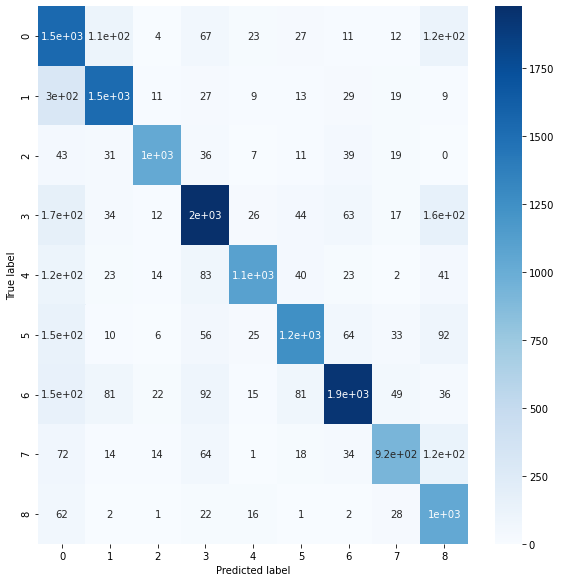

In [45]:
history3 = trainfold(3)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


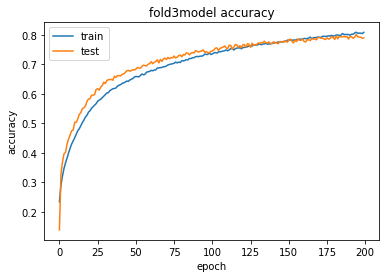

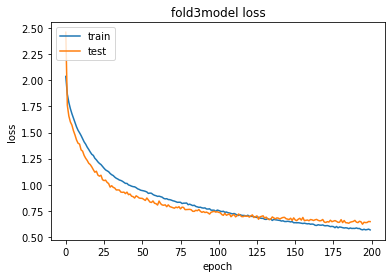

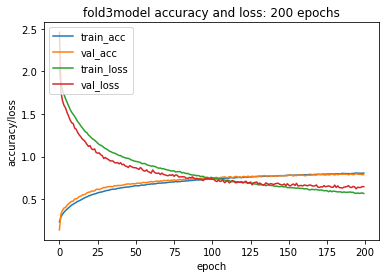

In [46]:
plot_graphs(3, history3)

In [47]:
# Fold 4

model = Sequential()
input_shape=(70, 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 70, 128)           512       
_________________________________________________________________
batch_normalization_16 (Batc (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 35, 128)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_17 (Batc (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 17, 128)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2176)            

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(62464, 70, 1)
Epoch 1/200
244/244 [==============================] - ETA: 0s - loss: 1.9965 - accuracy: 0.2529
Epoch 00001: accuracy improved from -inf to 0.25290, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 34s 141ms/step - loss: 1.9965 - accuracy: 0.2529 - val_loss: 2.1773 - val_accuracy: 0.2284
Epoch 2/200
244/244 [==============================] - ETA: 0s - loss: 1.8592 - accuracy: 0.3050
Epoch 00002: accuracy improved from 0.25290 to 0.30499, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 34s 139ms/step - loss: 1.8592 - accuracy: 0.3050 - val_loss: 1.7414 - val_accuracy: 0.3448
Epoch 3/

244/244 [==============================] - ETA: 0s - loss: 1.1459 - accuracy: 0.5810
Epoch 00024: accuracy improved from 0.57588 to 0.58102, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 35s 145ms/step - loss: 1.1459 - accuracy: 0.5810 - val_loss: 1.0365 - val_accuracy: 0.6192
Epoch 25/200
244/244 [==============================] - ETA: 0s - loss: 1.1350 - accuracy: 0.5865
Epoch 00025: accuracy improved from 0.58102 to 0.58647, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 35s 143ms/step - loss: 1.1350 - accuracy: 0.5865 - val_loss: 0.9923 - val_accuracy: 0.6409
Epoch 26/200
244/244 [==============================] - ETA: 0s - loss: 1.1124 - accuracy: 0.5966
Epoch 00026: accuracy improved from 0.58647 to 0.59662, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 38s 154ms/step - loss: 1.1124 - accuracy: 0.5966 - val_loss: 1.0044 - val_accuracy: 0.6261
Epoch 27

Epoch 49/200
244/244 [==============================] - ETA: 0s - loss: 0.9190 - accuracy: 0.6724
Epoch 00049: accuracy improved from 0.67165 to 0.67242, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 46s 190ms/step - loss: 0.9190 - accuracy: 0.6724 - val_loss: 0.8236 - val_accuracy: 0.7016
Epoch 50/200
244/244 [==============================] - ETA: 0s - loss: 0.9055 - accuracy: 0.6774
Epoch 00050: accuracy improved from 0.67242 to 0.67741, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 38s 156ms/step - loss: 0.9055 - accuracy: 0.6774 - val_loss: 0.8424 - val_accuracy: 0.6959
Epoch 51/200
244/244 [==============================] - ETA: 0s - loss: 0.9056 - accuracy: 0.6777
Epoch 00051: accuracy improved from 0.67741 to 0.67769, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 40s 163ms/step - loss: 0.9056 - accuracy: 0.6777 - val_loss: 0.8535 - val_accuracy: 0.

244/244 [==============================] - ETA: 0s - loss: 0.7938 - accuracy: 0.7212
Epoch 00074: accuracy improved from 0.71910 to 0.72117, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 38s 157ms/step - loss: 0.7938 - accuracy: 0.7212 - val_loss: 0.7515 - val_accuracy: 0.7433
Epoch 75/200
244/244 [==============================] - ETA: 0s - loss: 0.7909 - accuracy: 0.7211
Epoch 00075: accuracy did not improve from 0.72117
244/244 [==============================] - 35s 143ms/step - loss: 0.7909 - accuracy: 0.7211 - val_loss: 0.7499 - val_accuracy: 0.7362
Epoch 76/200
244/244 [==============================] - ETA: 0s - loss: 0.7814 - accuracy: 0.7258
Epoch 00076: accuracy improved from 0.72117 to 0.72583, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 36s 146ms/step - loss: 0.7814 - accuracy: 0.7258 - val_loss: 0.7381 - val_accuracy: 0.7424
Epoch 77/200
244/244 [==============================] - ETA:

Epoch 100/200
244/244 [==============================] - ETA: 0s - loss: 0.7164 - accuracy: 0.7530
Epoch 00100: accuracy improved from 0.75096 to 0.75301, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 33s 134ms/step - loss: 0.7164 - accuracy: 0.7530 - val_loss: 0.7160 - val_accuracy: 0.7564
Epoch 101/200
244/244 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.7541
Epoch 00101: accuracy improved from 0.75301 to 0.75415, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 33s 134ms/step - loss: 0.7056 - accuracy: 0.7541 - val_loss: 0.6985 - val_accuracy: 0.7670
Epoch 102/200
244/244 [==============================] - ETA: 0s - loss: 0.6996 - accuracy: 0.7563
Epoch 00102: accuracy improved from 0.75415 to 0.75632, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 34s 140ms/step - loss: 0.6996 - accuracy: 0.7563 - val_loss: 0.7007 - val_accuracy:

Epoch 126/200
244/244 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.7758
Epoch 00126: accuracy did not improve from 0.77997
244/244 [==============================] - 33s 136ms/step - loss: 0.6511 - accuracy: 0.7758 - val_loss: 0.6676 - val_accuracy: 0.7761
Epoch 127/200
244/244 [==============================] - ETA: 0s - loss: 0.6424 - accuracy: 0.7797
Epoch 00127: accuracy did not improve from 0.77997
244/244 [==============================] - 35s 142ms/step - loss: 0.6424 - accuracy: 0.7797 - val_loss: 0.6554 - val_accuracy: 0.7777
Epoch 128/200
244/244 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.7813
Epoch 00128: accuracy improved from 0.77997 to 0.78135, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 37s 150ms/step - loss: 0.6420 - accuracy: 0.7813 - val_loss: 0.6732 - val_accuracy: 0.7777
Epoch 129/200
244/244 [==============================] - ETA: 0s - loss: 0.6466 - accuracy: 0.78

Epoch 153/200
244/244 [==============================] - ETA: 0s - loss: 0.5932 - accuracy: 0.7997
Epoch 00153: accuracy improved from 0.79824 to 0.79972, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 36s 147ms/step - loss: 0.5932 - accuracy: 0.7997 - val_loss: 0.6330 - val_accuracy: 0.7971
Epoch 154/200
244/244 [==============================] - ETA: 0s - loss: 0.5972 - accuracy: 0.7975
Epoch 00154: accuracy did not improve from 0.79972
244/244 [==============================] - 37s 150ms/step - loss: 0.5972 - accuracy: 0.7975 - val_loss: 0.6501 - val_accuracy: 0.7869
Epoch 155/200
244/244 [==============================] - ETA: 0s - loss: 0.5992 - accuracy: 0.7988
Epoch 00155: accuracy did not improve from 0.79972
244/244 [==============================] - 37s 152ms/step - loss: 0.5992 - accuracy: 0.7988 - val_loss: 0.6389 - val_accuracy: 0.7916
Epoch 156/200
244/244 [==============================] - ETA: 0s - loss: 0.5925 - accuracy: 0.80

244/244 [==============================] - ETA: 0s - loss: 0.5611 - accuracy: 0.8115
Epoch 00179: accuracy did not improve from 0.81296
244/244 [==============================] - 42s 172ms/step - loss: 0.5611 - accuracy: 0.8115 - val_loss: 0.6219 - val_accuracy: 0.8009
Epoch 180/200
244/244 [==============================] - ETA: 0s - loss: 0.5560 - accuracy: 0.8161
Epoch 00180: accuracy improved from 0.81296 to 0.81610, saving model to fold_4_model_finalvalence.hdf5
244/244 [==============================] - 42s 174ms/step - loss: 0.5560 - accuracy: 0.8161 - val_loss: 0.6359 - val_accuracy: 0.7957
Epoch 181/200
244/244 [==============================] - ETA: 0s - loss: 0.5544 - accuracy: 0.8134
Epoch 00181: accuracy did not improve from 0.81610
244/244 [==============================] - 41s 170ms/step - loss: 0.5544 - accuracy: 0.8134 - val_loss: 0.6215 - val_accuracy: 0.7980
Epoch 182/200
244/244 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.8138
Epoch 00182

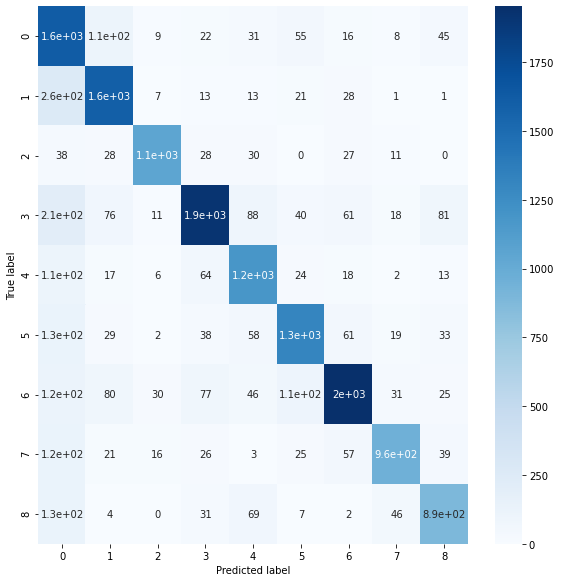

In [48]:
history4 = trainfold(4)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


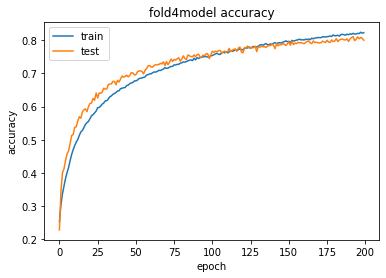

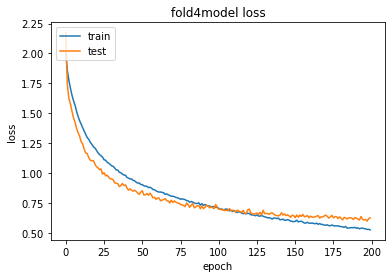

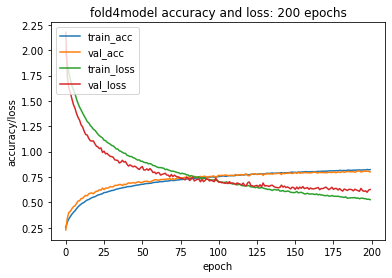

In [50]:
plot_graphs(4, history4)

In [51]:
# Fold 5

model = Sequential()
input_shape=(70, 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 70, 128)           512       
_________________________________________________________________
batch_normalization_18 (Batc (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 35, 128)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_19 (Batc (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 17, 128)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2176)            

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(62464, 70, 1)
Epoch 1/200
244/244 [==============================] - ETA: 0s - loss: 2.0294 - accuracy: 0.2269
Epoch 00001: accuracy improved from -inf to 0.22695, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 43s 174ms/step - loss: 2.0294 - accuracy: 0.2269 - val_loss: 2.3267 - val_accuracy: 0.1815
Epoch 2/200
244/244 [==============================] - ETA: 0s - loss: 1.8775 - accuracy: 0.2900
Epoch 00002: accuracy improved from 0.22695 to 0.29001, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 43s 174ms/step - loss: 1.8775 - accuracy: 0.2900 - val_loss: 1.7694 - val_accuracy: 0.3283
Epoch 3/

Epoch 24/200
244/244 [==============================] - ETA: 0s - loss: 1.1743 - accuracy: 0.5664 ETA: 0s - loss: 1.1749 - accuracy: 0.56
Epoch 00024: accuracy improved from 0.56407 to 0.56636, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 41s 168ms/step - loss: 1.1743 - accuracy: 0.5664 - val_loss: 1.0567 - val_accuracy: 0.6106
Epoch 25/200
244/244 [==============================] - ETA: 0s - loss: 1.1634 - accuracy: 0.5707
Epoch 00025: accuracy improved from 0.56636 to 0.57071, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 40s 163ms/step - loss: 1.1634 - accuracy: 0.5707 - val_loss: 1.0377 - val_accuracy: 0.6192
Epoch 26/200
244/244 [==============================] - ETA: 0s - loss: 1.1517 - accuracy: 0.5780
Epoch 00026: accuracy improved from 0.57071 to 0.57803, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 39s 161ms/step - loss: 1.1517 - accuracy: 0.57

Epoch 49/200
244/244 [==============================] - ETA: 0s - loss: 0.9451 - accuracy: 0.6589
Epoch 00049: accuracy improved from 0.65503 to 0.65894, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 39s 158ms/step - loss: 0.9451 - accuracy: 0.6589 - val_loss: 0.8644 - val_accuracy: 0.6938
Epoch 50/200
244/244 [==============================] - ETA: 0s - loss: 0.9389 - accuracy: 0.6623
Epoch 00050: accuracy improved from 0.65894 to 0.66233, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 40s 166ms/step - loss: 0.9389 - accuracy: 0.6623 - val_loss: 0.8592 - val_accuracy: 0.6919
Epoch 51/200
244/244 [==============================] - ETA: 0s - loss: 0.9313 - accuracy: 0.6669
Epoch 00051: accuracy improved from 0.66233 to 0.66694, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 40s 166ms/step - loss: 0.9313 - accuracy: 0.6669 - val_loss: 0.8693 - val_accuracy: 0.

244/244 [==============================] - ETA: 0s - loss: 0.8322 - accuracy: 0.7051
Epoch 00074: accuracy improved from 0.70492 to 0.70506, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 36s 147ms/step - loss: 0.8322 - accuracy: 0.7051 - val_loss: 0.7747 - val_accuracy: 0.7299
Epoch 75/200
244/244 [==============================] - ETA: 0s - loss: 0.8343 - accuracy: 0.7059
Epoch 00075: accuracy improved from 0.70506 to 0.70589, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 35s 145ms/step - loss: 0.8343 - accuracy: 0.7059 - val_loss: 0.7742 - val_accuracy: 0.7285
Epoch 76/200
244/244 [==============================] - ETA: 0s - loss: 0.8256 - accuracy: 0.7098
Epoch 00076: accuracy improved from 0.70589 to 0.70977, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 38s 154ms/step - loss: 0.8256 - accuracy: 0.7098 - val_loss: 0.7661 - val_accuracy: 0.7317
Epoch 77

244/244 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.7433
Epoch 00100: accuracy improved from 0.74007 to 0.74328, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 38s 157ms/step - loss: 0.7411 - accuracy: 0.7433 - val_loss: 0.7203 - val_accuracy: 0.7585
Epoch 101/200
244/244 [==============================] - ETA: 0s - loss: 0.7362 - accuracy: 0.7439
Epoch 00101: accuracy improved from 0.74328 to 0.74390, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 41s 168ms/step - loss: 0.7362 - accuracy: 0.7439 - val_loss: 0.7299 - val_accuracy: 0.7475
Epoch 102/200
244/244 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.7490
Epoch 00102: accuracy improved from 0.74390 to 0.74898, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 37s 151ms/step - loss: 0.7319 - accuracy: 0.7490 - val_loss: 0.7008 - val_accuracy: 0.7642
Epoch 

Epoch 126/200
244/244 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.7678
Epoch 00126: accuracy did not improve from 0.76857
244/244 [==============================] - 67s 276ms/step - loss: 0.6802 - accuracy: 0.7678 - val_loss: 0.6685 - val_accuracy: 0.7771
Epoch 127/200
244/244 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.7689
Epoch 00127: accuracy improved from 0.76857 to 0.76891, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 67s 273ms/step - loss: 0.6753 - accuracy: 0.7689 - val_loss: 0.6806 - val_accuracy: 0.7758
Epoch 128/200
244/244 [==============================] - ETA: 0s - loss: 0.6719 - accuracy: 0.7724
Epoch 00128: accuracy improved from 0.76891 to 0.77241, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 66s 272ms/step - loss: 0.6719 - accuracy: 0.7724 - val_loss: 0.6820 - val_accuracy: 0.7721
Epoch 129/200
244/244 [=====================

244/244 [==============================] - ETA: 0s - loss: 0.6194 - accuracy: 0.7888
Epoch 00152: accuracy improved from 0.78799 to 0.78884, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 68s 278ms/step - loss: 0.6194 - accuracy: 0.7888 - val_loss: 0.6378 - val_accuracy: 0.7914
Epoch 153/200
244/244 [==============================] - ETA: 0s - loss: 0.6196 - accuracy: 0.7901
Epoch 00153: accuracy improved from 0.78884 to 0.79010, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 68s 278ms/step - loss: 0.6196 - accuracy: 0.7901 - val_loss: 0.6482 - val_accuracy: 0.7887
Epoch 154/200
244/244 [==============================] - ETA: 0s - loss: 0.6165 - accuracy: 0.7915
Epoch 00154: accuracy improved from 0.79010 to 0.79150, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 67s 273ms/step - loss: 0.6165 - accuracy: 0.7915 - val_loss: 0.6407 - val_accuracy: 0.7895
Epoch 

244/244 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.8038
Epoch 00179: accuracy improved from 0.80158 to 0.80382, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 68s 279ms/step - loss: 0.5806 - accuracy: 0.8038 - val_loss: 0.6144 - val_accuracy: 0.8015
Epoch 180/200
244/244 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.8041
Epoch 00180: accuracy improved from 0.80382 to 0.80406, saving model to fold_5_model_finalvalence.hdf5
244/244 [==============================] - 67s 277ms/step - loss: 0.5813 - accuracy: 0.8041 - val_loss: 0.6345 - val_accuracy: 0.7935
Epoch 181/200
244/244 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.8028
Epoch 00181: accuracy did not improve from 0.80406
244/244 [==============================] - 67s 275ms/step - loss: 0.5870 - accuracy: 0.8028 - val_loss: 0.6300 - val_accuracy: 0.7942
Epoch 182/200
244/244 [==============================] - E

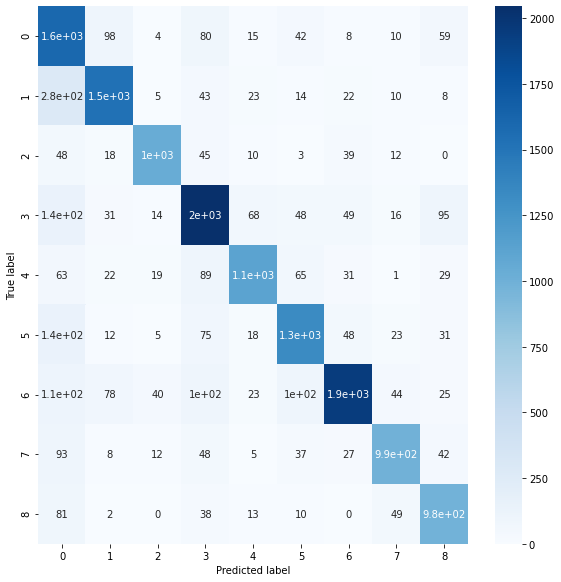

In [52]:
history5 = trainfold(5)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


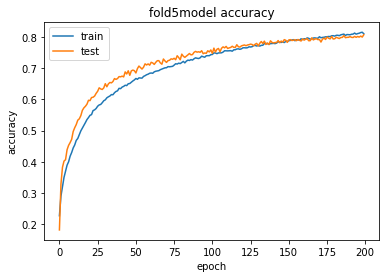

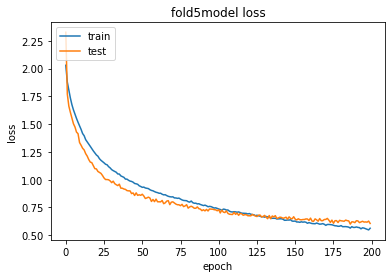

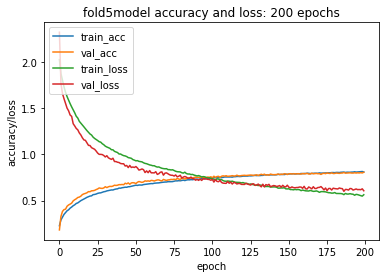

In [53]:
plot_graphs(5, history5)

# Like/Dislike

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 70, 128)           512       
_________________________________________________________________
batch_normalization_20 (Batc (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 35, 128)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_21 (Batc (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 17, 128)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2176)            

Epoch 18/200
244/244 [==============================] - ETA: 0s - loss: 1.1238 - accuracy: 0.5621
Epoch 00018: accuracy improved from 0.55728 to 0.56205, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 36s 146ms/step - loss: 1.1238 - accuracy: 0.5621 - val_loss: 1.0250 - val_accuracy: 0.5993
Epoch 19/200
244/244 [==============================] - ETA: 0s - loss: 1.1102 - accuracy: 0.5685
Epoch 00019: accuracy improved from 0.56205 to 0.56849, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 35s 144ms/step - loss: 1.1102 - accuracy: 0.5685 - val_loss: 1.0040 - val_accuracy: 0.6055
Epoch 20/200
244/244 [==============================] - ETA: 0s - loss: 1.0871 - accuracy: 0.5761
Epoch 00020: accuracy improved from 0.56849 to 0.57611, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 35s 145ms/step - loss: 1.0871 - accuracy: 0.5761 - val_loss: 0.9910 - val_accuracy: 0.6139
Epoc

Epoch 43/200
244/244 [==============================] - ETA: 0s - loss: 0.8919 - accuracy: 0.6568
Epoch 00043: accuracy did not improve from 0.65892
244/244 [==============================] - 36s 147ms/step - loss: 0.8919 - accuracy: 0.6568 - val_loss: 0.8070 - val_accuracy: 0.6960
Epoch 44/200
244/244 [==============================] - ETA: 0s - loss: 0.8827 - accuracy: 0.6629
Epoch 00044: accuracy improved from 0.65892 to 0.66291, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 36s 149ms/step - loss: 0.8827 - accuracy: 0.6629 - val_loss: 0.8205 - val_accuracy: 0.6924
Epoch 45/200
244/244 [==============================] - ETA: 0s - loss: 0.8739 - accuracy: 0.6648
Epoch 00045: accuracy improved from 0.66291 to 0.66485, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 36s 147ms/step - loss: 0.8739 - accuracy: 0.6648 - val_loss: 0.8019 - val_accuracy: 0.6954
Epoch 46/200
244/244 [==============================]

Epoch 69/200
244/244 [==============================] - ETA: 0s - loss: 0.7690 - accuracy: 0.7117
Epoch 00069: accuracy improved from 0.71073 to 0.71174, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 35s 145ms/step - loss: 0.7690 - accuracy: 0.7117 - val_loss: 0.7227 - val_accuracy: 0.7411
Epoch 70/200
244/244 [==============================] - ETA: 0s - loss: 0.7621 - accuracy: 0.7125
Epoch 00070: accuracy improved from 0.71174 to 0.71254, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 35s 145ms/step - loss: 0.7621 - accuracy: 0.7125 - val_loss: 0.7241 - val_accuracy: 0.7349
Epoch 71/200
244/244 [==============================] - ETA: 0s - loss: 0.7561 - accuracy: 0.7150
Epoch 00071: accuracy improved from 0.71254 to 0.71504, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 35s 143ms/step - loss: 0.7561 - accuracy: 0.7150 - val_loss: 0.7286 - val_accuracy: 0.7380
Epoc

Epoch 95/200
244/244 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.7482
Epoch 00095: accuracy improved from 0.74699 to 0.74822, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 35s 145ms/step - loss: 0.6822 - accuracy: 0.7482 - val_loss: 0.6906 - val_accuracy: 0.7608
Epoch 96/200
244/244 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.7528
Epoch 00096: accuracy improved from 0.74822 to 0.75283, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 36s 146ms/step - loss: 0.6751 - accuracy: 0.7528 - val_loss: 0.6742 - val_accuracy: 0.7590
Epoch 97/200
244/244 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.7508
Epoch 00097: accuracy did not improve from 0.75283
244/244 [==============================] - 36s 146ms/step - loss: 0.6757 - accuracy: 0.7508 - val_loss: 0.7014 - val_accuracy: 0.7568
Epoch 98/200
244/244 [==============================]

244/244 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.7773
Epoch 00121: accuracy improved from 0.77318 to 0.77731, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 36s 146ms/step - loss: 0.6169 - accuracy: 0.7773 - val_loss: 0.6528 - val_accuracy: 0.7764
Epoch 122/200
244/244 [==============================] - ETA: 0s - loss: 0.6146 - accuracy: 0.7786
Epoch 00122: accuracy improved from 0.77731 to 0.77861, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 36s 146ms/step - loss: 0.6146 - accuracy: 0.7786 - val_loss: 0.6617 - val_accuracy: 0.7773
Epoch 123/200
244/244 [==============================] - ETA: 0s - loss: 0.6122 - accuracy: 0.7801
Epoch 00123: accuracy improved from 0.77861 to 0.78015, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 36s 147ms/step - loss: 0.6122 - accuracy: 0.7801 - val_loss: 0.6365 - val_accuracy: 0.7811
Epoch 124/200
2

Epoch 148/200
244/244 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.7972
Epoch 00148: accuracy improved from 0.79676 to 0.79720, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 36s 150ms/step - loss: 0.5679 - accuracy: 0.7972 - val_loss: 0.6268 - val_accuracy: 0.7941
Epoch 149/200
244/244 [==============================] - ETA: 0s - loss: 0.5688 - accuracy: 0.7964
Epoch 00149: accuracy did not improve from 0.79720
244/244 [==============================] - 36s 149ms/step - loss: 0.5688 - accuracy: 0.7964 - val_loss: 0.6338 - val_accuracy: 0.7861
Epoch 150/200
244/244 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.7998
Epoch 00150: accuracy improved from 0.79720 to 0.79976, saving model to fold_1_model_finallike.hdf5
244/244 [==============================] - 36s 147ms/step - loss: 0.5608 - accuracy: 0.7998 - val_loss: 0.6447 - val_accuracy: 0.7863
Epoch 151/200
244/244 [===========================

244/244 [==============================] - ETA: 0s - loss: 0.5273 - accuracy: 0.8133
Epoch 00175: accuracy did not improve from 0.81671
244/244 [==============================] - 36s 146ms/step - loss: 0.5273 - accuracy: 0.8133 - val_loss: 0.6064 - val_accuracy: 0.8035
Epoch 176/200
244/244 [==============================] - ETA: 0s - loss: 0.5206 - accuracy: 0.8162
Epoch 00176: accuracy did not improve from 0.81671
244/244 [==============================] - 36s 147ms/step - loss: 0.5206 - accuracy: 0.8162 - val_loss: 0.6112 - val_accuracy: 0.8023
Epoch 177/200
244/244 [==============================] - ETA: 0s - loss: 0.5224 - accuracy: 0.8144
Epoch 00177: accuracy did not improve from 0.81671
244/244 [==============================] - 36s 146ms/step - loss: 0.5224 - accuracy: 0.8144 - val_loss: 0.6189 - val_accuracy: 0.8025
Epoch 178/200
244/244 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.8174
Epoch 00178: accuracy improved from 0.81671 to 0.81735, saving 

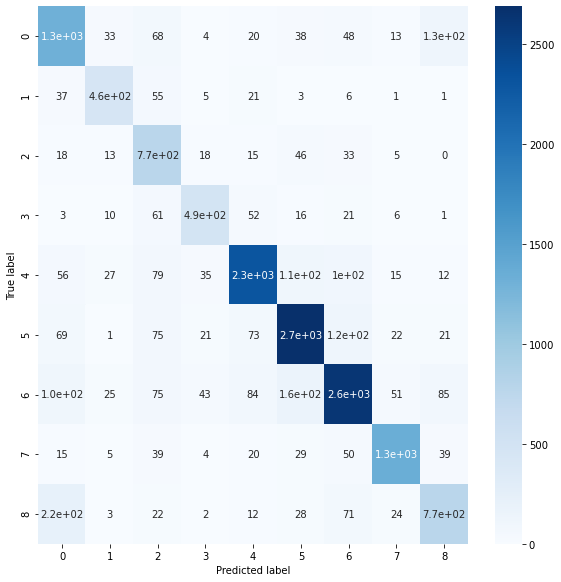

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


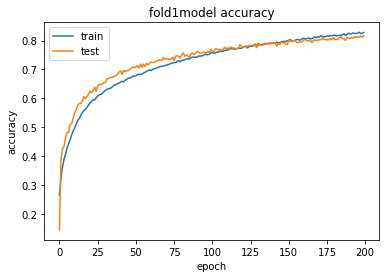

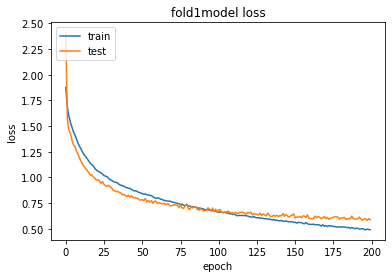

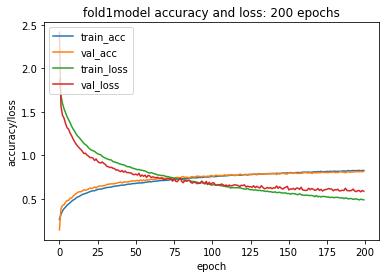

In [54]:
batch_size = 256
num_classes = 10
epochs = 200
input_shape=(70, 1)

def liketrainfold(foldnum):
    ### Preprocessing    
    with open('data_preprocessed_python\\fold_' + str(foldnum) + '_data_train_again3.npy', 'rb') as fileTrain:
        X  = np.load(fileTrain)
    
    with open('data_preprocessed_python\\fold_' + str(foldnum) + '_label_train_again3.npy', 'rb') as fileTrainL:
        Y  = np.load(fileTrainL)
    
    X = normalize(X)

    Arousal_Train = np.ravel(Y[:, [0]])
    Valence_Train = np.ravel(Y[:, [1]])
    Domain_Train = np.ravel(Y[:, [2]])
    Like_Train = np.ravel(Y[:, [3]])
    
    #######################################################################################
    Z = Like_Train
    #######################################################################################

    y_train = to_categorical(Z)
    print(y_train)

    x_train = np.array(X[:])
    
    with open('data_preprocessed_python\\fold_' + str(foldnum) + '_data_test_again3.npy', 'rb') as fileTrain:
        M  = np.load(fileTrain)
    
    with open('data_preprocessed_python\\fold_' + str(foldnum) + '_label_test_again3.npy', 'rb') as fileTrainL:
        N  = np.load(fileTrainL)
    M = normalize(M)

    Arousal_Test = np.ravel(N[:, [0]])
    Valence_Test = np.ravel(N[:, [1]])
    Domain_Test = np.ravel(N[:, [2]])
    Like_Test = np.ravel(N[:, [3]])
    
    #######################################################################################
    L = Like_Test
    #######################################################################################

    x_test = np.array(M[:])

    y_test = to_categorical(L)
    print(y_test)

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

    print(x_train.shape)
    
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint('fold_' + str(foldnum) + '_model_finallike.hdf5', monitor='accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)

    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint])
    
    print('Training Finished for fold' , foldnum)
    
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    print("score for fold", foldnum, "is", score)
    
    y_pred=model.predict(x_test)

    y_test1=np.argmax(y_test, axis=1)
    y_pred=np.argmax(y_pred,axis=1)

    cmatrix=confusion_matrix(y_test1, y_pred)

    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return history

# Fold 1

model = Sequential()
input_shape=(70, 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

likehistory1 = liketrainfold(1)

def plot_graphs(foldnum, history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('fold' + str(foldnum) + 'model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('fold' + str(foldnum) + 'model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    #trying to combine both
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('fold' + str(foldnum) + 'model accuracy and loss: 200 epochs')
    plt.ylabel('accuracy/loss')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc','train_loss','val_loss'], loc='upper left')
    plt.show()

plot_graphs(1, likehistory1)

In [55]:
# Fold 2

model = Sequential()
input_shape=(70, 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 70, 128)           512       
_________________________________________________________________
batch_normalization_22 (Batc (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 35, 128)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_23 (Batc (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 17, 128)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2176)            

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(62464, 70, 1)
Epoch 1/200
244/244 [==============================] - ETA: 0s - loss: 1.8466 - accuracy: 0.2795
Epoch 00001: accuracy improved from -inf to 0.27954, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 147ms/step - loss: 1.8466 - accuracy: 0.2795 - val_loss: 2.2006 - val_accuracy: 0.1512
Epoch 2/200
244/244 [==============================] - ETA: 0s - loss: 1.6672 - accuracy: 0.3270
Epoch 00002: accuracy improved from 0.27954 to 0.32702, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 35s 145ms/step - loss: 1.6672 - accuracy: 0.3270 - val_loss: 1.5595 - val_accuracy: 0.3756
Epoch 3/200
24

Epoch 25/200
244/244 [==============================] - ETA: 0s - loss: 1.0361 - accuracy: 0.6058
Epoch 00025: accuracy improved from 0.59825 to 0.60577, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 1.0361 - accuracy: 0.6058 - val_loss: 0.9331 - val_accuracy: 0.6440
Epoch 26/200
244/244 [==============================] - ETA: 0s - loss: 1.0227 - accuracy: 0.6100
Epoch 00026: accuracy improved from 0.60577 to 0.61003, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 1.0227 - accuracy: 0.6100 - val_loss: 0.9368 - val_accuracy: 0.6438
Epoch 27/200
244/244 [==============================] - ETA: 0s - loss: 1.0093 - accuracy: 0.6147
Epoch 00027: accuracy improved from 0.61003 to 0.61474, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 146ms/step - loss: 1.0093 - accuracy: 0.6147 - val_loss: 0.9424 - val_accuracy: 0.6452
Epoc

244/244 [==============================] - ETA: 0s - loss: 0.8457 - accuracy: 0.6855
Epoch 00050: accuracy improved from 0.68217 to 0.68550, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 0.8457 - accuracy: 0.6855 - val_loss: 0.7945 - val_accuracy: 0.7059
Epoch 51/200
244/244 [==============================] - ETA: 0s - loss: 0.8379 - accuracy: 0.6876
Epoch 00051: accuracy improved from 0.68550 to 0.68761, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 147ms/step - loss: 0.8379 - accuracy: 0.6876 - val_loss: 0.7986 - val_accuracy: 0.7061
Epoch 52/200
244/244 [==============================] - ETA: 0s - loss: 0.8355 - accuracy: 0.6901
Epoch 00052: accuracy improved from 0.68761 to 0.69006, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 147ms/step - loss: 0.8355 - accuracy: 0.6901 - val_loss: 0.7878 - val_accuracy: 0.7062
Epoch 53/200
244/

Epoch 76/200
244/244 [==============================] - ETA: 0s - loss: 0.7350 - accuracy: 0.7292
Epoch 00076: accuracy improved from 0.72413 to 0.72917, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 146ms/step - loss: 0.7350 - accuracy: 0.7292 - val_loss: 0.7114 - val_accuracy: 0.7423
Epoch 77/200
244/244 [==============================] - ETA: 0s - loss: 0.7361 - accuracy: 0.7265
Epoch 00077: accuracy did not improve from 0.72917
244/244 [==============================] - 36s 148ms/step - loss: 0.7361 - accuracy: 0.7265 - val_loss: 0.7085 - val_accuracy: 0.7429
Epoch 78/200
244/244 [==============================] - ETA: 0s - loss: 0.7367 - accuracy: 0.7262
Epoch 00078: accuracy did not improve from 0.72917
244/244 [==============================] - 36s 147ms/step - loss: 0.7367 - accuracy: 0.7262 - val_loss: 0.7205 - val_accuracy: 0.7367
Epoch 79/200
244/244 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.7302
Epoc

Epoch 103/200
244/244 [==============================] - ETA: 0s - loss: 0.6710 - accuracy: 0.7541
Epoch 00103: accuracy did not improve from 0.75528
244/244 [==============================] - 35s 145ms/step - loss: 0.6710 - accuracy: 0.7541 - val_loss: 0.6833 - val_accuracy: 0.7572
Epoch 104/200
244/244 [==============================] - ETA: 0s - loss: 0.6706 - accuracy: 0.7558
Epoch 00104: accuracy improved from 0.75528 to 0.75583, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 146ms/step - loss: 0.6706 - accuracy: 0.7558 - val_loss: 0.6858 - val_accuracy: 0.7612
Epoch 105/200
244/244 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.7576
Epoch 00105: accuracy improved from 0.75583 to 0.75759, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 146ms/step - loss: 0.6643 - accuracy: 0.7576 - val_loss: 0.6842 - val_accuracy: 0.7620
Epoch 106/200
244/244 [===========================

Epoch 130/200
244/244 [==============================] - ETA: 0s - loss: 0.6074 - accuracy: 0.7790
Epoch 00130: accuracy improved from 0.77648 to 0.77898, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 0.6074 - accuracy: 0.7790 - val_loss: 0.6549 - val_accuracy: 0.7738
Epoch 131/200
244/244 [==============================] - ETA: 0s - loss: 0.6157 - accuracy: 0.7757
Epoch 00131: accuracy did not improve from 0.77898
244/244 [==============================] - 37s 150ms/step - loss: 0.6157 - accuracy: 0.7757 - val_loss: 0.6457 - val_accuracy: 0.7807
Epoch 132/200
244/244 [==============================] - ETA: 0s - loss: 0.6077 - accuracy: 0.7790
Epoch 00132: accuracy improved from 0.77898 to 0.77899, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 0.6077 - accuracy: 0.7790 - val_loss: 0.6374 - val_accuracy: 0.7792
Epoch 133/200
244/244 [===========================

Epoch 157/200
244/244 [==============================] - ETA: 0s - loss: 0.5731 - accuracy: 0.7952
Epoch 00157: accuracy improved from 0.79415 to 0.79518, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 146ms/step - loss: 0.5731 - accuracy: 0.7952 - val_loss: 0.6304 - val_accuracy: 0.7875
Epoch 158/200
244/244 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.7969
Epoch 00158: accuracy improved from 0.79518 to 0.79691, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 146ms/step - loss: 0.5636 - accuracy: 0.7969 - val_loss: 0.6257 - val_accuracy: 0.7875
Epoch 159/200
244/244 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.7943
Epoch 00159: accuracy did not improve from 0.79691
244/244 [==============================] - 36s 147ms/step - loss: 0.5728 - accuracy: 0.7943 - val_loss: 0.6277 - val_accuracy: 0.7881
Epoch 160/200
244/244 [===========================

Epoch 184/200
244/244 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.8067
Epoch 00184: accuracy did not improve from 0.81015
244/244 [==============================] - 36s 147ms/step - loss: 0.5423 - accuracy: 0.8067 - val_loss: 0.5920 - val_accuracy: 0.8034
Epoch 185/200
244/244 [==============================] - ETA: 0s - loss: 0.5293 - accuracy: 0.8131
Epoch 00185: accuracy improved from 0.81015 to 0.81311, saving model to fold_2_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 0.5293 - accuracy: 0.8131 - val_loss: 0.5924 - val_accuracy: 0.8028
Epoch 186/200
244/244 [==============================] - ETA: 0s - loss: 0.5273 - accuracy: 0.8126
Epoch 00186: accuracy did not improve from 0.81311
244/244 [==============================] - 36s 148ms/step - loss: 0.5273 - accuracy: 0.8126 - val_loss: 0.5983 - val_accuracy: 0.8064
Epoch 187/200
244/244 [==============================] - ETA: 0s - loss: 0.5316 - accuracy: 0.8108


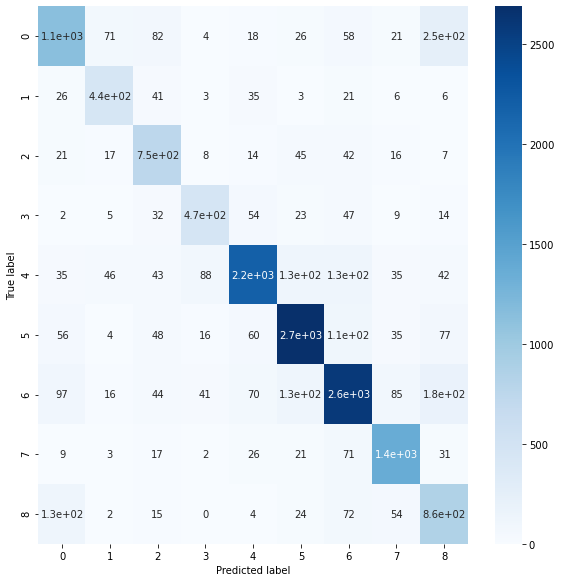

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


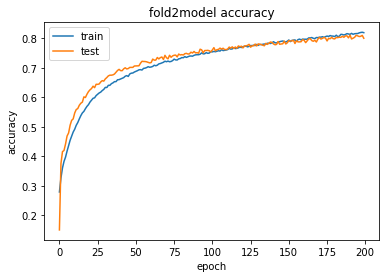

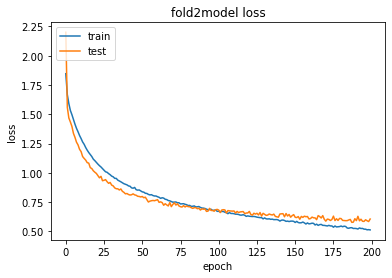

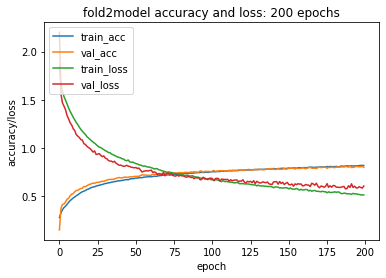

In [56]:
likehistory2 = liketrainfold(2)

plot_graphs(2, likehistory2)

In [57]:
# Fold 3

model = Sequential()
input_shape=(70, 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 70, 128)           512       
_________________________________________________________________
batch_normalization_24 (Batc (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 35, 128)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_25 (Batc (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 17, 128)           0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2176)            

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(62464, 70, 1)
Epoch 1/200
244/244 [==============================] - ETA: 0s - loss: 1.8291 - accuracy: 0.2673
Epoch 00001: accuracy improved from -inf to 0.26731, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 36s 147ms/step - loss: 1.8291 - accuracy: 0.2673 - val_loss: 2.0186 - val_accuracy: 0.2620
Epoch 2/200
244/244 [==============================] - ETA: 0s - loss: 1.6655 - accuracy: 0.3242
Epoch 00002: accuracy improved from 0.26731 to 0.32419, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 36s 146ms/step - loss: 1.6655 - accuracy: 0.3242 - val_loss: 1.5396 - val_accuracy: 0.3965
Epoch 3/200
24

Epoch 25/200
244/244 [==============================] - ETA: 0s - loss: 1.0560 - accuracy: 0.5841
Epoch 00025: accuracy improved from 0.58006 to 0.58408, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 36s 147ms/step - loss: 1.0560 - accuracy: 0.5841 - val_loss: 0.9684 - val_accuracy: 0.6187
Epoch 26/200
244/244 [==============================] - ETA: 0s - loss: 1.0449 - accuracy: 0.5897
Epoch 00026: accuracy improved from 0.58408 to 0.58972, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 36s 149ms/step - loss: 1.0449 - accuracy: 0.5897 - val_loss: 0.9486 - val_accuracy: 0.6297
Epoch 27/200
244/244 [==============================] - ETA: 0s - loss: 1.0375 - accuracy: 0.5932
Epoch 00027: accuracy improved from 0.58972 to 0.59321, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 37s 150ms/step - loss: 1.0375 - accuracy: 0.5932 - val_loss: 0.9437 - val_accuracy: 0.6290
Epoc

244/244 [==============================] - ETA: 0s - loss: 0.8670 - accuracy: 0.6677
Epoch 00050: accuracy improved from 0.66549 to 0.66766, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 36s 147ms/step - loss: 0.8670 - accuracy: 0.6677 - val_loss: 0.8244 - val_accuracy: 0.6888
Epoch 51/200
244/244 [==============================] - ETA: 0s - loss: 0.8619 - accuracy: 0.6695
Epoch 00051: accuracy improved from 0.66766 to 0.66946, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 0.8619 - accuracy: 0.6695 - val_loss: 0.8224 - val_accuracy: 0.6897
Epoch 52/200
244/244 [==============================] - ETA: 0s - loss: 0.8599 - accuracy: 0.6716
Epoch 00052: accuracy improved from 0.66946 to 0.67157, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 36s 149ms/step - loss: 0.8599 - accuracy: 0.6716 - val_loss: 0.8032 - val_accuracy: 0.6971
Epoch 53/200
244/

244/244 [==============================] - ETA: 0s - loss: 0.7624 - accuracy: 0.7156
Epoch 00075: accuracy improved from 0.71451 to 0.71561, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 0.7624 - accuracy: 0.7156 - val_loss: 0.7408 - val_accuracy: 0.7270
Epoch 76/200
244/244 [==============================] - ETA: 0s - loss: 0.7649 - accuracy: 0.7153
Epoch 00076: accuracy did not improve from 0.71561
244/244 [==============================] - 36s 148ms/step - loss: 0.7649 - accuracy: 0.7153 - val_loss: 0.7452 - val_accuracy: 0.7280
Epoch 77/200
244/244 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.7187
Epoch 00077: accuracy improved from 0.71561 to 0.71865, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 37s 151ms/step - loss: 0.7574 - accuracy: 0.7187 - val_loss: 0.7439 - val_accuracy: 0.7324
Epoch 78/200
244/244 [==============================] - ETA: 0s - 

Epoch 102/200
244/244 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.7504
Epoch 00102: accuracy improved from 0.74915 to 0.75035, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 36s 147ms/step - loss: 0.6841 - accuracy: 0.7504 - val_loss: 0.6936 - val_accuracy: 0.7600
Epoch 103/200
244/244 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.7506
Epoch 00103: accuracy improved from 0.75035 to 0.75062, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 0.6833 - accuracy: 0.7506 - val_loss: 0.6800 - val_accuracy: 0.7596
Epoch 104/200
244/244 [==============================] - ETA: 0s - loss: 0.6773 - accuracy: 0.7551
Epoch 00104: accuracy improved from 0.75062 to 0.75507, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 0.6773 - accuracy: 0.7551 - val_loss: 0.6902 - val_accuracy: 0.7577
E

244/244 [==============================] - ETA: 0s - loss: 0.6260 - accuracy: 0.7719
Epoch 00128: accuracy did not improve from 0.77323
244/244 [==============================] - 37s 150ms/step - loss: 0.6260 - accuracy: 0.7719 - val_loss: 0.6566 - val_accuracy: 0.7752
Epoch 129/200
244/244 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.7740
Epoch 00129: accuracy improved from 0.77323 to 0.77400, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 0.6288 - accuracy: 0.7740 - val_loss: 0.6736 - val_accuracy: 0.7697
Epoch 130/200
244/244 [==============================] - ETA: 0s - loss: 0.6238 - accuracy: 0.7736
Epoch 00130: accuracy did not improve from 0.77400
244/244 [==============================] - 36s 148ms/step - loss: 0.6238 - accuracy: 0.7736 - val_loss: 0.6673 - val_accuracy: 0.7716
Epoch 131/200
244/244 [==============================] - ETA: 0s - loss: 0.6182 - accuracy: 0.7765
Epoch 00131: a

Epoch 156/200
244/244 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.7917
Epoch 00156: accuracy did not improve from 0.79294
244/244 [==============================] - 36s 149ms/step - loss: 0.5812 - accuracy: 0.7917 - val_loss: 0.6326 - val_accuracy: 0.7832
Epoch 157/200
244/244 [==============================] - ETA: 0s - loss: 0.5802 - accuracy: 0.7946
Epoch 00157: accuracy improved from 0.79294 to 0.79455, saving model to fold_3_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 0.5802 - accuracy: 0.7946 - val_loss: 0.6463 - val_accuracy: 0.7893
Epoch 158/200
244/244 [==============================] - ETA: 0s - loss: 0.5780 - accuracy: 0.7937
Epoch 00158: accuracy did not improve from 0.79455
244/244 [==============================] - 36s 147ms/step - loss: 0.5780 - accuracy: 0.7937 - val_loss: 0.6469 - val_accuracy: 0.7868
Epoch 159/200
244/244 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.7958


Epoch 183/200
244/244 [==============================] - ETA: 0s - loss: 0.5441 - accuracy: 0.8088
Epoch 00183: accuracy did not improve from 0.80954
244/244 [==============================] - 36s 147ms/step - loss: 0.5441 - accuracy: 0.8088 - val_loss: 0.6221 - val_accuracy: 0.7994
Epoch 184/200
244/244 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.8084
Epoch 00184: accuracy did not improve from 0.80954
244/244 [==============================] - 36s 148ms/step - loss: 0.5417 - accuracy: 0.8084 - val_loss: 0.6254 - val_accuracy: 0.7970
Epoch 185/200
244/244 [==============================] - ETA: 0s - loss: 0.5435 - accuracy: 0.8086
Epoch 00185: accuracy did not improve from 0.80954
244/244 [==============================] - 37s 151ms/step - loss: 0.5435 - accuracy: 0.8086 - val_loss: 0.6197 - val_accuracy: 0.8006
Epoch 186/200
244/244 [==============================] - ETA: 0s - loss: 0.5382 - accuracy: 0.8111
Epoch 00186: accuracy improved from 0.80954 to 0.

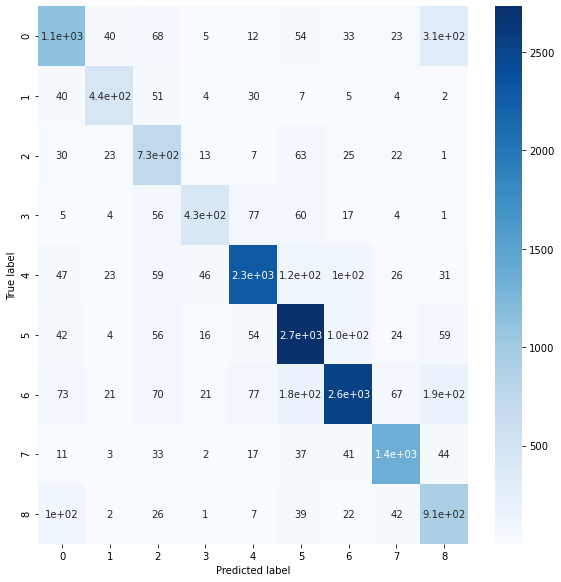

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


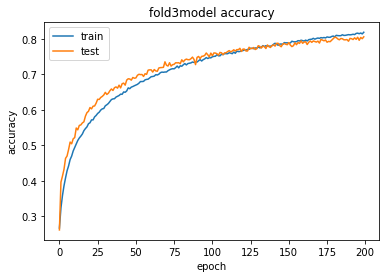

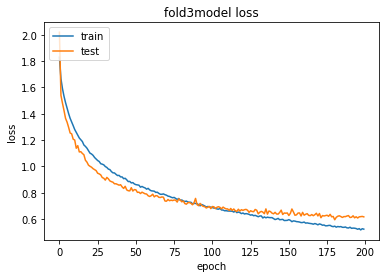

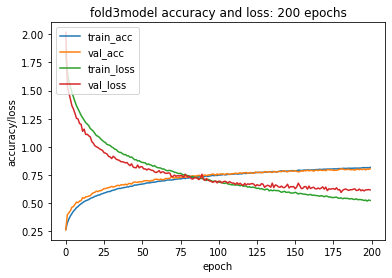

In [58]:
likehistory3 = liketrainfold(3)

plot_graphs(3, likehistory3)

In [59]:
# Fold 4

model = Sequential()
input_shape=(70, 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 70, 128)           512       
_________________________________________________________________
batch_normalization_26 (Batc (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 35, 128)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_27 (Batc (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 17, 128)           0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 2176)            

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(62464, 70, 1)
Epoch 1/200
244/244 [==============================] - ETA: 0s - loss: 1.8843 - accuracy: 0.2595
Epoch 00001: accuracy improved from -inf to 0.25951, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 36s 149ms/step - loss: 1.8843 - accuracy: 0.2595 - val_loss: 1.9880 - val_accuracy: 0.2356
Epoch 2/200
244/244 [==============================] - ETA: 0s - loss: 1.6747 - accuracy: 0.3162
Epoch 00002: accuracy improved from 0.25951 to 0.31625, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 1.6747 - accuracy: 0.3162 - val_loss: 1.5763 - val_accuracy: 0.3477
Epoch 3/200
24

Epoch 25/200
244/244 [==============================] - ETA: 0s - loss: 0.9991 - accuracy: 0.6171
Epoch 00025: accuracy improved from 0.61327 to 0.61712, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 36s 149ms/step - loss: 0.9991 - accuracy: 0.6171 - val_loss: 0.9222 - val_accuracy: 0.6464
Epoch 26/200
244/244 [==============================] - ETA: 0s - loss: 0.9847 - accuracy: 0.6253
Epoch 00026: accuracy improved from 0.61712 to 0.62526, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 37s 151ms/step - loss: 0.9847 - accuracy: 0.6253 - val_loss: 0.9363 - val_accuracy: 0.6399
Epoch 27/200
244/244 [==============================] - ETA: 0s - loss: 0.9767 - accuracy: 0.6267
Epoch 00027: accuracy improved from 0.62526 to 0.62673, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 36s 149ms/step - loss: 0.9767 - accuracy: 0.6267 - val_loss: 0.9166 - val_accuracy: 0.6528
Epoc

Epoch 50/200
244/244 [==============================] - ETA: 0s - loss: 0.8291 - accuracy: 0.6899
Epoch 00050: accuracy improved from 0.68852 to 0.68992, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 0.8291 - accuracy: 0.6899 - val_loss: 0.8123 - val_accuracy: 0.7024
Epoch 51/200
244/244 [==============================] - ETA: 0s - loss: 0.8251 - accuracy: 0.6882
Epoch 00051: accuracy did not improve from 0.68992
244/244 [==============================] - 36s 148ms/step - loss: 0.8251 - accuracy: 0.6882 - val_loss: 0.8102 - val_accuracy: 0.6947
Epoch 52/200
244/244 [==============================] - ETA: 0s - loss: 0.8205 - accuracy: 0.6920
Epoch 00052: accuracy improved from 0.68992 to 0.69200, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 0.8205 - accuracy: 0.6920 - val_loss: 0.7927 - val_accuracy: 0.7040
Epoch 53/200
244/244 [==============================]

Epoch 76/200
244/244 [==============================] - ETA: 0s - loss: 0.7275 - accuracy: 0.7300
Epoch 00076: accuracy did not improve from 0.73077
244/244 [==============================] - 37s 153ms/step - loss: 0.7275 - accuracy: 0.7300 - val_loss: 0.7386 - val_accuracy: 0.7364
Epoch 77/200
244/244 [==============================] - ETA: 0s - loss: 0.7261 - accuracy: 0.7315
Epoch 00077: accuracy improved from 0.73077 to 0.73149, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 36s 149ms/step - loss: 0.7261 - accuracy: 0.7315 - val_loss: 0.7085 - val_accuracy: 0.7468
Epoch 78/200
244/244 [==============================] - ETA: 0s - loss: 0.7225 - accuracy: 0.7322
Epoch 00078: accuracy improved from 0.73149 to 0.73225, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 36s 148ms/step - loss: 0.7225 - accuracy: 0.7322 - val_loss: 0.7253 - val_accuracy: 0.7369
Epoch 79/200
244/244 [==============================]

244/244 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.7588
Epoch 00102: accuracy did not improve from 0.75949
244/244 [==============================] - 35s 143ms/step - loss: 0.6592 - accuracy: 0.7588 - val_loss: 0.6855 - val_accuracy: 0.7595
Epoch 103/200
244/244 [==============================] - ETA: 0s - loss: 0.6623 - accuracy: 0.7577
Epoch 00103: accuracy did not improve from 0.75949
244/244 [==============================] - 35s 145ms/step - loss: 0.6623 - accuracy: 0.7577 - val_loss: 0.6747 - val_accuracy: 0.7659
Epoch 104/200
244/244 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.7609
Epoch 00104: accuracy improved from 0.75949 to 0.76089, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 35s 143ms/step - loss: 0.6512 - accuracy: 0.7609 - val_loss: 0.6816 - val_accuracy: 0.7610
Epoch 105/200
244/244 [==============================] - ETA: 0s - loss: 0.6500 - accuracy: 0.7631
Epoch 00105: a

Epoch 128/200
244/244 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.7827
Epoch 00128: accuracy improved from 0.78202 to 0.78271, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 39s 162ms/step - loss: 0.6034 - accuracy: 0.7827 - val_loss: 0.6493 - val_accuracy: 0.7785
Epoch 129/200
244/244 [==============================] - ETA: 0s - loss: 0.6003 - accuracy: 0.7818
Epoch 00129: accuracy did not improve from 0.78271
244/244 [==============================] - 39s 160ms/step - loss: 0.6003 - accuracy: 0.7818 - val_loss: 0.6607 - val_accuracy: 0.7747
Epoch 130/200
244/244 [==============================] - ETA: 0s - loss: 0.5977 - accuracy: 0.7856
Epoch 00130: accuracy improved from 0.78271 to 0.78562, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 39s 161ms/step - loss: 0.5977 - accuracy: 0.7856 - val_loss: 0.6546 - val_accuracy: 0.7792
Epoch 131/200
244/244 [===========================

Epoch 155/200
244/244 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.8022
Epoch 00155: accuracy improved from 0.80147 to 0.80217, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 39s 160ms/step - loss: 0.5557 - accuracy: 0.8022 - val_loss: 0.6214 - val_accuracy: 0.7969
Epoch 156/200
244/244 [==============================] - ETA: 0s - loss: 0.5483 - accuracy: 0.8052
Epoch 00156: accuracy improved from 0.80217 to 0.80520, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 40s 163ms/step - loss: 0.5483 - accuracy: 0.8052 - val_loss: 0.6271 - val_accuracy: 0.7938
Epoch 157/200
244/244 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.8015
Epoch 00157: accuracy did not improve from 0.80520
244/244 [==============================] - 40s 163ms/step - loss: 0.5553 - accuracy: 0.8015 - val_loss: 0.6257 - val_accuracy: 0.7936
Epoch 158/200
244/244 [===========================

244/244 [==============================] - ETA: 0s - loss: 0.5198 - accuracy: 0.8149
Epoch 00182: accuracy did not improve from 0.81625
244/244 [==============================] - 39s 160ms/step - loss: 0.5198 - accuracy: 0.8149 - val_loss: 0.6111 - val_accuracy: 0.8003
Epoch 183/200
244/244 [==============================] - ETA: 0s - loss: 0.5173 - accuracy: 0.8173
Epoch 00183: accuracy improved from 0.81625 to 0.81729, saving model to fold_4_model_finallike.hdf5
244/244 [==============================] - 39s 161ms/step - loss: 0.5173 - accuracy: 0.8173 - val_loss: 0.6209 - val_accuracy: 0.7999
Epoch 184/200
244/244 [==============================] - ETA: 0s - loss: 0.5200 - accuracy: 0.8157
Epoch 00184: accuracy did not improve from 0.81729
244/244 [==============================] - 39s 161ms/step - loss: 0.5200 - accuracy: 0.8157 - val_loss: 0.6477 - val_accuracy: 0.7936
Epoch 185/200
244/244 [==============================] - ETA: 0s - loss: 0.5228 - accuracy: 0.8161
Epoch 00185: a

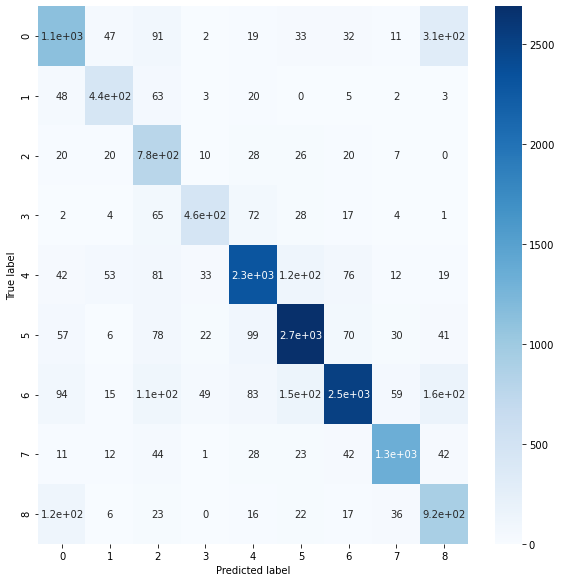

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


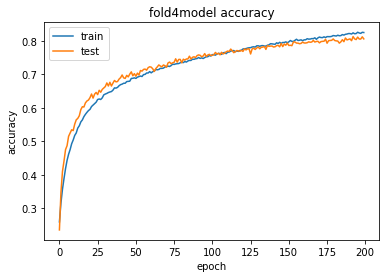

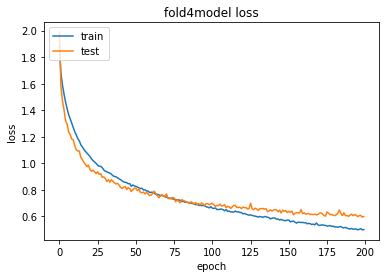

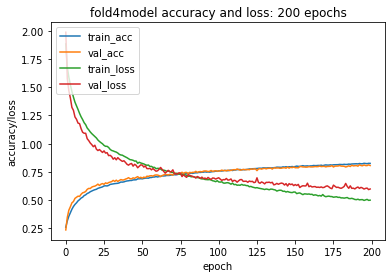

In [60]:
likehistory4 = liketrainfold(4)

plot_graphs(4, likehistory4)

In [61]:
# Fold 5

model = Sequential()
input_shape=(70, 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 70, 128)           512       
_________________________________________________________________
batch_normalization_28 (Batc (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 35, 128)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_29 (Batc (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 17, 128)           0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 2176)            

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(62464, 70, 1)
Epoch 1/200
244/244 [==============================] - ETA: 0s - loss: 1.8808 - accuracy: 0.2706
Epoch 00001: accuracy improved from -inf to 0.27057, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 40s 163ms/step - loss: 1.8808 - accuracy: 0.2706 - val_loss: 1.9899 - val_accuracy: 0.2462
Epoch 2/200
244/244 [==============================] - ETA: 0s - loss: 1.6881 - accuracy: 0.3187
Epoch 00002: accuracy improved from 0.27057 to 0.31874, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 39s 159ms/step - loss: 1.6881 - accuracy: 0.3187 - val_loss: 1.5742 - val_accuracy: 0.3633
Epoch 3/200
24

244/244 [==============================] - ETA: 0s - loss: 1.0613 - accuracy: 0.5973
Epoch 00024: accuracy improved from 0.58868 to 0.59727, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 42s 171ms/step - loss: 1.0613 - accuracy: 0.5973 - val_loss: 0.9616 - val_accuracy: 0.6322
Epoch 25/200
244/244 [==============================] - ETA: 0s - loss: 1.0515 - accuracy: 0.5972
Epoch 00025: accuracy did not improve from 0.59727
244/244 [==============================] - 41s 170ms/step - loss: 1.0515 - accuracy: 0.5972 - val_loss: 0.9693 - val_accuracy: 0.6325
Epoch 26/200
244/244 [==============================] - ETA: 0s - loss: 1.0366 - accuracy: 0.6024
Epoch 00026: accuracy improved from 0.59727 to 0.60241, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 39s 161ms/step - loss: 1.0366 - accuracy: 0.6024 - val_loss: 0.9811 - val_accuracy: 0.6249
Epoch 27/200
244/244 [==============================] - ETA: 0s - 

Epoch 49/200
244/244 [==============================] - ETA: 0s - loss: 0.8536 - accuracy: 0.6799
Epoch 00049: accuracy improved from 0.67408 to 0.67991, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 38s 157ms/step - loss: 0.8536 - accuracy: 0.6799 - val_loss: 0.7902 - val_accuracy: 0.7105
Epoch 50/200
244/244 [==============================] - ETA: 0s - loss: 0.8547 - accuracy: 0.6826
Epoch 00050: accuracy improved from 0.67991 to 0.68255, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 39s 160ms/step - loss: 0.8547 - accuracy: 0.6826 - val_loss: 0.8111 - val_accuracy: 0.7030
Epoch 51/200
244/244 [==============================] - ETA: 0s - loss: 0.8446 - accuracy: 0.6833
Epoch 00051: accuracy improved from 0.68255 to 0.68332, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 39s 160ms/step - loss: 0.8446 - accuracy: 0.6833 - val_loss: 0.7951 - val_accuracy: 0.7054
Epoc

Epoch 75/200
244/244 [==============================] - ETA: 0s - loss: 0.7515 - accuracy: 0.7234
Epoch 00075: accuracy improved from 0.72283 to 0.72338, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 39s 161ms/step - loss: 0.7515 - accuracy: 0.7234 - val_loss: 0.7341 - val_accuracy: 0.7374
Epoch 76/200
244/244 [==============================] - ETA: 0s - loss: 0.7445 - accuracy: 0.7230
Epoch 00076: accuracy did not improve from 0.72338
244/244 [==============================] - 39s 159ms/step - loss: 0.7445 - accuracy: 0.7230 - val_loss: 0.7567 - val_accuracy: 0.7312
Epoch 77/200
244/244 [==============================] - ETA: 0s - loss: 0.7463 - accuracy: 0.7242
Epoch 00077: accuracy improved from 0.72338 to 0.72421, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 39s 159ms/step - loss: 0.7463 - accuracy: 0.7242 - val_loss: 0.7261 - val_accuracy: 0.7390
Epoch 78/200
244/244 [==============================]

Epoch 101/200
244/244 [==============================] - ETA: 0s - loss: 0.6683 - accuracy: 0.7583
Epoch 00101: accuracy improved from 0.75440 to 0.75832, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 39s 159ms/step - loss: 0.6683 - accuracy: 0.7583 - val_loss: 0.6943 - val_accuracy: 0.7553
Epoch 102/200
244/244 [==============================] - ETA: 0s - loss: 0.6679 - accuracy: 0.7566
Epoch 00102: accuracy did not improve from 0.75832
244/244 [==============================] - 38s 157ms/step - loss: 0.6679 - accuracy: 0.7566 - val_loss: 0.6915 - val_accuracy: 0.7629
Epoch 103/200
244/244 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.7615
Epoch 00103: accuracy improved from 0.75832 to 0.76149, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 39s 161ms/step - loss: 0.6613 - accuracy: 0.7615 - val_loss: 0.6678 - val_accuracy: 0.7666
Epoch 104/200
244/244 [===========================

Epoch 128/200
244/244 [==============================] - ETA: 0s - loss: 0.6107 - accuracy: 0.7807
Epoch 00128: accuracy improved from 0.77963 to 0.78069, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 43s 177ms/step - loss: 0.6107 - accuracy: 0.7807 - val_loss: 0.6515 - val_accuracy: 0.7809
Epoch 129/200
244/244 [==============================] - ETA: 0s - loss: 0.6067 - accuracy: 0.7829
Epoch 00129: accuracy improved from 0.78069 to 0.78287, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 46s 189ms/step - loss: 0.6067 - accuracy: 0.7829 - val_loss: 0.6334 - val_accuracy: 0.7891
Epoch 130/200
244/244 [==============================] - ETA: 0s - loss: 0.6113 - accuracy: 0.7787
Epoch 00130: accuracy did not improve from 0.78287
244/244 [==============================] - 54s 223ms/step - loss: 0.6113 - accuracy: 0.7787 - val_loss: 0.6295 - val_accuracy: 0.7834
Epoch 131/200
244/244 [===========================

244/244 [==============================] - ETA: 0s - loss: 0.5726 - accuracy: 0.7960
Epoch 00154: accuracy did not improve from 0.79766
244/244 [==============================] - 42s 172ms/step - loss: 0.5726 - accuracy: 0.7960 - val_loss: 0.6144 - val_accuracy: 0.7983
Epoch 155/200
244/244 [==============================] - ETA: 0s - loss: 0.5674 - accuracy: 0.7963
Epoch 00155: accuracy did not improve from 0.79766
244/244 [==============================] - 41s 169ms/step - loss: 0.5674 - accuracy: 0.7963 - val_loss: 0.6226 - val_accuracy: 0.7942
Epoch 156/200
244/244 [==============================] - ETA: 0s - loss: 0.5652 - accuracy: 0.7987
Epoch 00156: accuracy improved from 0.79766 to 0.79872, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 41s 169ms/step - loss: 0.5652 - accuracy: 0.7987 - val_loss: 0.6226 - val_accuracy: 0.7915
Epoch 157/200
244/244 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.8031
Epoch 00157: a

244/244 [==============================] - ETA: 0s - loss: 0.5324 - accuracy: 0.8124
Epoch 00180: accuracy did not improve from 0.81649
244/244 [==============================] - 39s 160ms/step - loss: 0.5324 - accuracy: 0.8124 - val_loss: 0.6034 - val_accuracy: 0.8035
Epoch 181/200
244/244 [==============================] - ETA: 0s - loss: 0.5246 - accuracy: 0.8154
Epoch 00181: accuracy did not improve from 0.81649
244/244 [==============================] - 39s 161ms/step - loss: 0.5246 - accuracy: 0.8154 - val_loss: 0.5915 - val_accuracy: 0.8060
Epoch 182/200
244/244 [==============================] - ETA: 0s - loss: 0.5193 - accuracy: 0.8175
Epoch 00182: accuracy improved from 0.81649 to 0.81746, saving model to fold_5_model_finallike.hdf5
244/244 [==============================] - 40s 163ms/step - loss: 0.5193 - accuracy: 0.8175 - val_loss: 0.5916 - val_accuracy: 0.8118
Epoch 183/200
244/244 [==============================] - ETA: 0s - loss: 0.5242 - accuracy: 0.8162
Epoch 00183: a

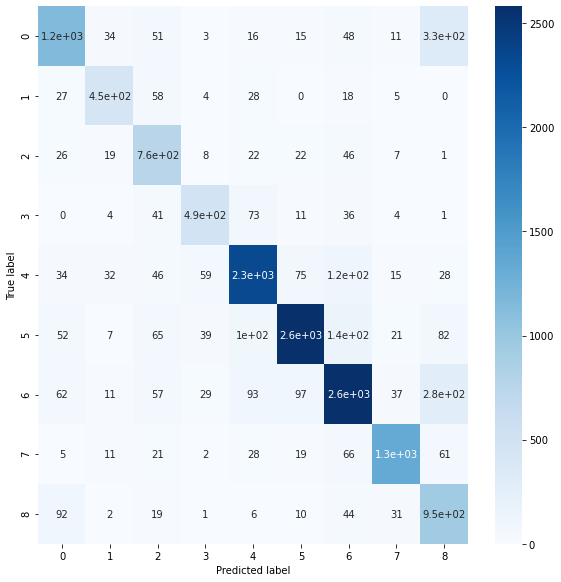

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


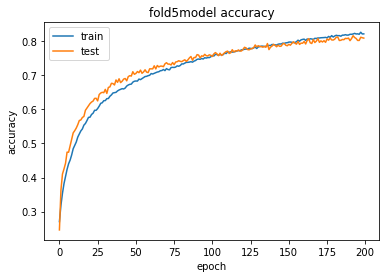

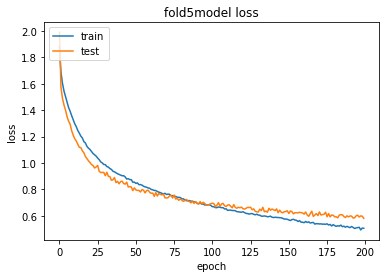

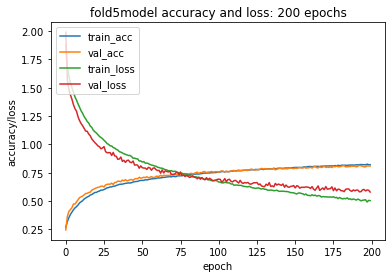

In [62]:
likehistory5 = liketrainfold(5)

plot_graphs(5, likehistory5)

# DOMINANCE

In [66]:
batch_size = 256
num_classes = 10
epochs = 200
input_shape=(70, 1)

def domaintrainfold(foldnum):
    ### Preprocessing    
    with open('data_preprocessed_python\\fold_' + str(foldnum) + '_data_train_again3.npy', 'rb') as fileTrain:
        X  = np.load(fileTrain)
    
    with open('data_preprocessed_python\\fold_' + str(foldnum) + '_label_train_again3.npy', 'rb') as fileTrainL:
        Y  = np.load(fileTrainL)
    
    X = normalize(X)

    Arousal_Train = np.ravel(Y[:, [0]])
    Valence_Train = np.ravel(Y[:, [1]])
    Domain_Train = np.ravel(Y[:, [2]])
    Like_Train = np.ravel(Y[:, [3]])
    
    #######################################################################################
    Z = Domain_Train
    #######################################################################################

    y_train = to_categorical(Z)
    print(y_train)

    x_train = np.array(X[:])
    
    with open('data_preprocessed_python\\fold_' + str(foldnum) + '_data_test_again3.npy', 'rb') as fileTrain:
        M  = np.load(fileTrain)
    
    with open('data_preprocessed_python\\fold_' + str(foldnum) + '_label_test_again3.npy', 'rb') as fileTrainL:
        N  = np.load(fileTrainL)
    M = normalize(M)

    Arousal_Test = np.ravel(N[:, [0]])
    Valence_Test = np.ravel(N[:, [1]])
    Domain_Test = np.ravel(N[:, [2]])
    Like_Test = np.ravel(N[:, [3]])
    
    #######################################################################################
    L = Domain_Train
    #######################################################################################

    x_test = np.array(M[:])

    y_test = to_categorical(L)
    print(y_test)

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

    print(x_train.shape)
    
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint('fold_' + str(foldnum) + '_model_finaldomain.hdf5', monitor='accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)

    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint])
    
    print('Training Finished for fold' , foldnum)
    
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    print("score for fold", foldnum, "is", score)
    
    y_pred=model.predict(x_test)

    y_test1=np.argmax(y_test, axis=1)
    y_pred=np.argmax(y_pred,axis=1)

    cmatrix=confusion_matrix(y_test1, y_pred)

    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return history

# Fold 1

model = Sequential()
input_shape=(70, 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

domainhistory1 = domaintrainfold(1)

def plot_graphs(foldnum, history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('fold' + str(foldnum) + 'model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('fold' + str(foldnum) + 'model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    #trying to combine both
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('fold' + str(foldnum) + 'model accuracy and loss: 200 epochs')
    plt.ylabel('accuracy/loss')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc','train_loss','val_loss'], loc='upper left')
    plt.show()

plot_graphs(1, domainhistory1)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 70, 128)           512       
_________________________________________________________________
batch_normalization_36 (Batc (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 35, 128)           0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_37 (Batc (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 17, 128)           0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 2176)            

ValueError: Data cardinality is ambiguous:
  x sizes: 15616
  y sizes: 62464
Please provide data which shares the same first dimension.

In [ ]:
# Fold 2

model = Sequential()
input_shape=(70, 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
domainhistory5 = domaintrainfold(5)

plot_graphs(5, domainhistory5)